In [474]:
import pandas as pd
import os
import sys
import pickle

In [475]:
sys.path.append("../src/ga4_mlops/pipelines")

In [476]:
from data_preparation_utils import extract_column_names

In [477]:
def predict(abt_predict: pd.DataFrame, model) -> pd.DataFrame:
    """Make predictions on a given data frame.

    Args:
        abt_predict (pd.DataFrame): data frame to predict on
        model (): any model with predict_proba method

    Returns:
        pd.DataFrame: data frame with predicted scores
    """
    # logger.info("Applying model to get predictions...")

    info_cols, num_cols, cat_cols, _ = extract_column_names(abt_predict)

    scores = model.predict_proba(abt_predict[num_cols + cat_cols])[:, 1]

    predictions = abt_predict.loc[:, info_cols]
    predictions["y_score"] = scores

    return predictions

In [478]:
abt_test = pd.read_csv('../data/05_model_input/abt_test.csv')

In [479]:
with open('../data/06_models/model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [480]:
info_cols, num_cols, cat_cols, target_col = extract_column_names(abt_test)

In [481]:
model.predict_proba(abt_test[num_cols + cat_cols])

array([[0.50072634, 0.4992737 ],
       [0.50072634, 0.4992737 ],
       [0.50072634, 0.4992737 ],
       ...,
       [0.50072634, 0.4992737 ],
       [0.50071234, 0.49928766],
       [0.50072634, 0.49927363]], dtype=float32)

In [482]:
raw_preds = predict(abt_test, model)
raw_preds

,i_full_visitor_id,i_visit_start_time,i_date,y_score
0,6.589392e+06,1.612042e+15,20210130,0.499274
1,8.733518e+07,1.611970e+15,20210130,0.499274
2,2.134926e+06,1.612026e+15,20210130,0.499274
3,4.547660e+09,1.611976e+15,20210130,0.499288
4,4.154220e+06,1.612008e+15,20210130,0.499274
...,...,...,...,...
1995,3.305593e+07,1.612022e+15,20210130,0.499553
1996,5.512692e+06,1.612046e+15,20210130,0.499274
1997,7.203708e+07,1.612014e+15,20210130,0.499274
1998,2.420217e+07,1.612017e+15,20210130,0.499288


In [483]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [484]:
calibration_model = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")

In [485]:
calibration_model.fit(
    X = abt_test[num_cols + cat_cols],
    y = abt_test[target_col]
)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(alpha=3.002149270068002e-08,
                                               base_score=0.5, booster='gbtree',
                                               callbacks=None,
                                               colsample_bylevel=0.6024218656598881,
                                               colsample_bynode=1,
                                               colsample_bytree=1,
                                               early_stopping_rounds=30,
                                               enable_categorical=False,
                                               eta=0.0001615729117434752,
                                               eval_metric='auc',
                                               feature_types=None, gamma=0,
                                               gpu_id=-1,
                                               grow_policy='lossguide',
                                               importance_type=None,
                                               interaction_constraints='',
                                               lambda=4.983476846377076e-06,
                                               learning_rate=0.000161572912,
                                               max_bin=256,
                                               max_cat_threshold=64,
                                               max_cat_to_onehot=4,
                                               max_delta_step=0, max_depth=4,
                                               max_leaves=0, min_child_weight=1,
                                               missing=nan,
                                               monotone_constraints='()',
                                               n_estimators=200, n_jobs=0, ...))

In [486]:
calibrated_preds = predict(abt_test, calibration_model)
calibrated_preds

,i_full_visitor_id,i_visit_start_time,i_date,y_score
0,6.589392e+06,1.612042e+15,20210130,0.012840
1,8.733518e+07,1.611970e+15,20210130,0.012840
2,2.134926e+06,1.612026e+15,20210130,0.012840
3,4.547660e+09,1.611976e+15,20210130,0.013986
4,4.154220e+06,1.612008e+15,20210130,0.012840
...,...,...,...,...
1995,3.305593e+07,1.612022e+15,20210130,0.068475
1996,5.512692e+06,1.612046e+15,20210130,0.012824
1997,7.203708e+07,1.612014e+15,20210130,0.012840
1998,2.420217e+07,1.612017e+15,20210130,0.013986


In [487]:
import numpy as np

In [488]:
np.min(raw_preds["y_score"]), np.mean(raw_preds["y_score"]), np.max(raw_preds["y_score"])

(0.4992734, 0.49932778, 0.50013286)

In [489]:
np.min(calibrated_preds["y_score"]), np.mean(calibrated_preds["y_score"]), np.max(calibrated_preds["y_score"])

(0.012815034948289394, 0.04001429752167314, 0.728651762008667)

In [490]:
# n_bins = int(max(5, abt_test.shape[0]/100))
n_bins = 25

In [491]:
raw_calibration_curve = calibration_curve(abt_test[target_col], raw_preds["y_score"], strategy="quantile", n_bins=n_bins)

In [492]:
calibrated_calibration_curve = calibration_curve(abt_test[target_col], calibrated_preds["y_score"], strategy="quantile", n_bins=n_bins)

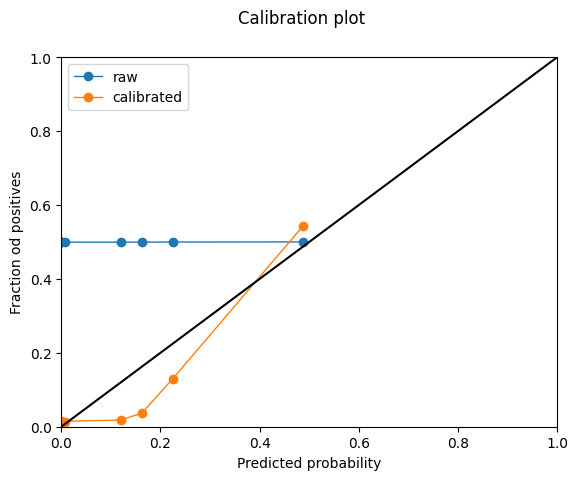

In [499]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots()
plt.plot(raw_calibration_curve[0], raw_calibration_curve[1], marker='o', linewidth=1, label='raw')
plt.plot(calibrated_calibration_curve[0], calibrated_calibration_curve[1], marker='o', linewidth=1, label='calibrated')

ax.add_line(mlines.Line2D([0, 1], [0, 1], color='black'))
fig.suptitle('Calibration plot')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('Fraction od positives')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.legend()
plt.show()

In [500]:
type(calibration_model)

sklearn.calibration.CalibratedClassifierCV